## Wykrywanie anomalii w rzeczywistych zbiorach 

    Zadanie wyjaśnimy na podstawie zbioru danych SMTP - zawierającego anomalie (ataki) SMTP.
    
    Ten zbiór i inne rzeczywiste zbiory danych do wykorzystania w I części laboratorium pobieramy z: 
    http://odds.cs.stonybrook.edu/
    

### SMTP dataset

http://odds.cs.stonybrook.edu/smtp-kddcup99-dataset/

Smtp (KDDCUP99)	\
points:      95156	\
dimenstions: 3	\
outliers:     30 (0.03%)

Zbiór zawiera wybrane (zagregowane) cechy połączeń TCP, spośród których 30 (oznaczone jako outliers) to próby ataku, pozostałe - normalny ruch (inliers).

Zadanie polega na zbadaniu skuteczności różnych metod wykrywania anomalii do detekcji tych ataków.  


In [ ]:
!pip install h5py
!pip install tables

In [3]:
import h5py
import numpy as np

f = h5py.File('../datasets/smtp.mat', 'r')
print(f.keys())

y1 = np.array(f.get('y'))
x1 = np.array(f.get('X')).T
y1_ = np.array(f.get('y')).ravel().astype(dtype=np.uint8)

<KeysViewHDF5 ['X', 'y']>


In [4]:
import scipy.io
import pandas as pd

mat = scipy.io.loadmat('../datasets/pendigits.mat')
print(mat.keys())

x = np.array(mat.get('X'))
y = np.array(mat.get('y')).ravel().astype(dtype=np.uint8)

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


# Data description

X zawiera obserwacje (wiersze) - cechy połączeń
y - ocznaczenie połączeń jako ruch normalny (inlier) lub atak (outlier)


In [5]:
x_df = pd.DataFrame(x)
y_df = pd.DataFrame(y)

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_ood, y_ood = x[y == 1], y[y == 1]

### X description

                0            1            2            3            4   \
count  6870.000000  6870.000000  6870.000000  6870.000000  6870.000000   
mean      0.374275     0.843479     0.429537     0.853413     0.542893   
std       0.340456     0.170745     0.255325     0.176687     0.342895   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.018554     0.759604     0.246029     0.740792     0.222747   
50%       0.310905     0.886605     0.422299     0.932528     0.605002   
75%       0.624531     1.000000     0.594701     1.000000     0.832904   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                5            6            7            8            9   \
count  6870.000000  6870.000000  6870.000000  6870.000000  6870.000000   
mean      0.694592     0.515240     0.481723     0.545207     0.343081   
std       0.237558     0.309844     0.294426     0.334941     0.278823   
min       0.000000     0.000000     0

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
       [<Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
        <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>],
       [<Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>,
        <Axes: title={'center': '10'}>, <Axes: title={'center': '11'}>],
       [<Axes: title={'center': '12'}>, <Axes: title={'center': '13'}>,
        <Axes: title={'center': '14'}>, <Axes: title={'center': '15'}>]],
      dtype=object)

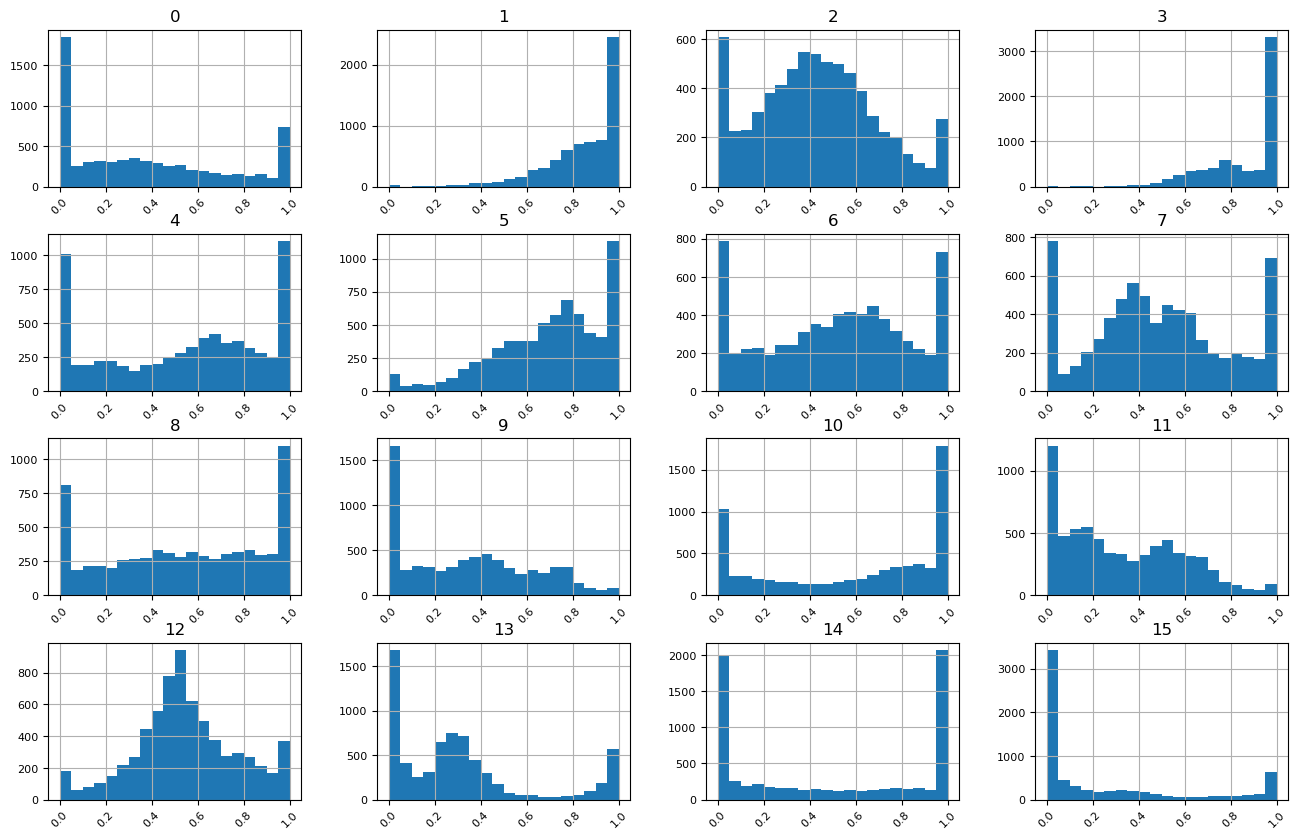

In [7]:
print(x_df.describe())

x_df.hist(figsize=(16,10), bins=20, xlabelsize=8, ylabelsize=8, xrot=45)

In [8]:
print(x_df.head())

        0         1         2         3         4         5         6   \
0  0.46977  1.000000  0.270463  0.812819  0.578246  0.371700  0.261600   
1  0.00000  0.887156  0.275891  1.000000  0.421130  0.758004  0.296085   
2  0.00000  0.568410  0.321768  0.682326  0.729609  0.903012  1.000000   
3  0.00000  1.000000  0.070717  0.918846  0.047145  0.686851  0.189419   
4  0.00000  0.671233  0.482427  0.826872  1.000000  1.000000  0.818488   

         7         8         9         10        11        12        13  \
0  0.000000  0.000000  0.234127  0.565463  0.533163  1.000000  0.901008   
1  0.449351  0.150966  0.150846  0.376991  0.000000  0.689886  0.019072   
2  1.000000  0.758613  0.752239  0.504585  0.505997  0.285181  0.255833   
3  0.457426  0.863797  0.345193  1.000000  0.456065  0.753983  0.231130   
4  0.802209  0.596662  0.603270  0.398628  0.403493  0.320968  0.200536   

         14        15  
0  0.402439  0.982795  
1  1.000000  0.057418  
2  0.162748  0.000000  
3  0.660

### Y description

                 0
count  6870.000000
mean      0.022707
std       0.148980
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


array([[<Axes: title={'center': '0'}>]], dtype=object)

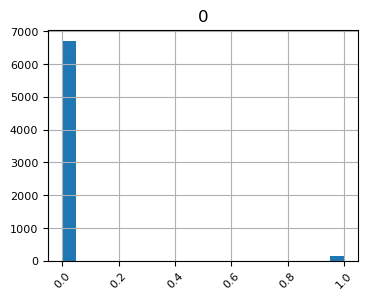

In [9]:
print(y_df.describe())

y_df.hist(figsize=(4,3), bins=20, xlabelsize=8, ylabelsize=8, xrot=45)

In [10]:
print(y_df.head())

   0
0  0
1  0
2  0
3  0
4  0


## LOF

In [24]:
from sklearn.neighbors import LocalOutlierFactor

# model = LocalOutlierFactor(n_neighbors=20, novelty=False, contamination='auto')
model = LocalOutlierFactor(n_neighbors=20, novelty=False, contamination='auto')

y_pred = model.fit_predict(x)  # 1 - inlier, -1 - outlier

In [25]:
y_pred[y_pred==1] = 0    # inliers
y_pred[y_pred==-1] = 1   # outliers

In [26]:
print("\nTrue labels:")
print(np.array(np.unique(y, return_counts=True)))

print("\nPredicted labels:")
print(np.array(np.unique(y_pred, return_counts=True)))


True labels:
[[   0    1]
 [6714  156]]

Predicted labels:
[[   0    1]
 [6774   96]]


In [27]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_pred)

array([[6626,   88],
       [ 148,    8]], dtype=int64)

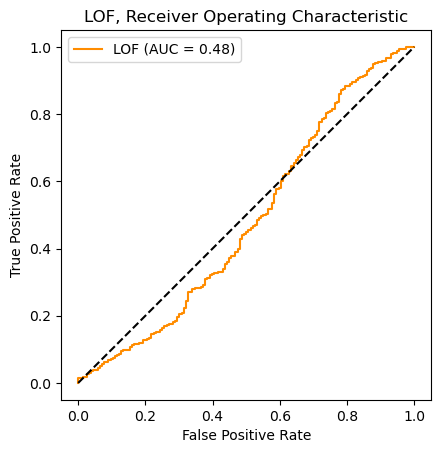

In [28]:
### plot ROC curve

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

model.fit(x)
y_pred = model.negative_outlier_factor_


RocCurveDisplay.from_predictions(
    y,
    y_pred,
    name="LOF",
    color="darkorange",
    pos_label=0
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LOF, Receiver Operating Characteristic")
plt.legend()
plt.show()


-1.0682277461275869
-1.074440788187092
-1.0981105396259698


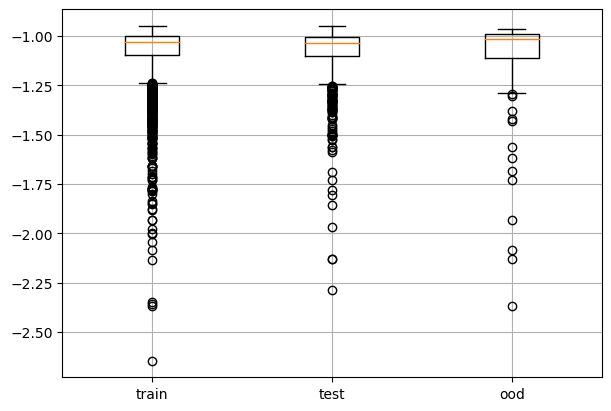

In [29]:
model = LocalOutlierFactor(n_neighbors=20, novelty=True)
model.fit(x_train)

train_scores = model.score_samples(x_train)
test_scores = model.score_samples(x_test)
ood_scores = model.score_samples(x_ood)

if 1:
    print(np.mean(train_scores))
    print(np.mean(test_scores))
    print(np.mean(ood_scores))


# boxplot
fig, ax1 = plt.subplots(figsize=(6, 4), constrained_layout=True)

labels = ['train', 'test', 'ood']
#ax1.set_ylim([40, 65])
ax1.boxplot([train_scores, test_scores, ood_scores], labels=labels)
ax1.grid()

plt.show()

## Isolation Forest

In [34]:
from sklearn.ensemble import IsolationForest


model = IsolationForest(n_estimators=2000, max_samples='auto', contamination=float(0.1), max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

y_pred = model.fit_predict(x)  # 1 - inlier, -1 - outlier

In [35]:
y_pred[y_pred==1] = 0    # inliers
y_pred[y_pred==-1] = 1   # outliers

In [36]:

print("\nTrue labels:")
print(np.array(np.unique(y, return_counts=True)))

print("\nPredicted labels:")
print(np.array(np.unique(y_pred, return_counts=True)))


True labels:
[[   0    1]
 [6714  156]]

Predicted labels:
[[   0    1]
 [6183  687]]


In [37]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_pred)

array([[6146,  568],
       [  37,  119]], dtype=int64)

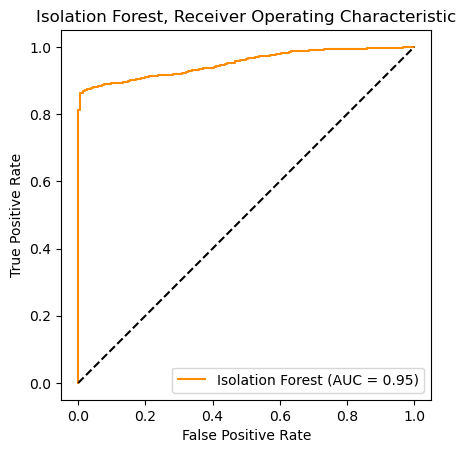

In [38]:

### plot ROC curve

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

model.fit(x)
y_pred = model.decision_function(x)


RocCurveDisplay.from_predictions(
    y,
    y_pred,
    name="Isolation Forest",
    color="darkorange",
    pos_label=0
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Isolation Forest, Receiver Operating Characteristic")
plt.legend()
plt.show()


-0.4950243901131428
-0.4956452060102871
-0.5808178975953555


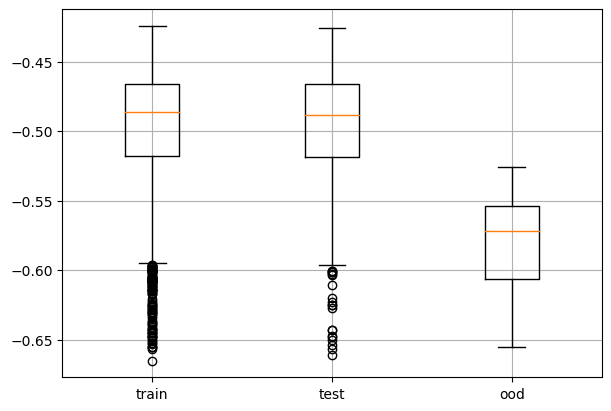

In [39]:
train_scores = model.score_samples(x_train)
test_scores = model.score_samples(x_test)
ood_scores = model.score_samples(x_ood)

if 1:
    print(np.mean(train_scores))
    print(np.mean(test_scores))
    print(np.mean(ood_scores))


# boxplot
fig, ax1 = plt.subplots(figsize=(6, 4), constrained_layout=True)

labels = ['train', 'test', 'ood']
#ax1.set_ylim([40, 65])
ax1.boxplot([train_scores, test_scores, ood_scores], labels=labels)
ax1.grid()

plt.show()

## IRW - Integrated Rank-Weighted depth

fitted IRWdepth model with 1000 projections in 5496 dimensions
--- 730.3863785266876 seconds ---
0.25000003376810764
0.24927060582898453


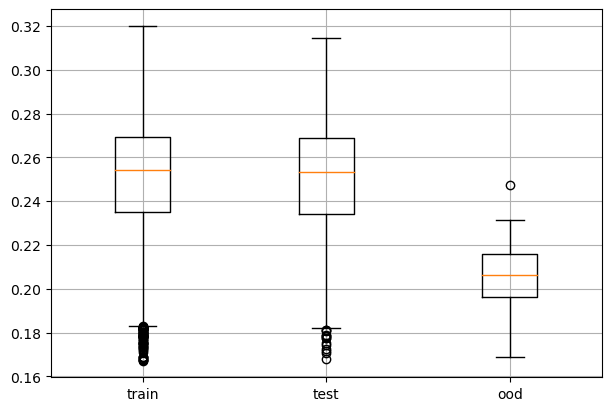

In [40]:
import time
from IRW_score import IRWdepth

model = IRWdepth()
nproj = 1000
model.fit(x_train, nproj)

start_time = time.time()

train_scores = [model.score(row) for row in x_train]
test_scores = [model.score(row) for row in x_test]
ood_scores = [model.score(row) for row in x_ood]

print("--- %s seconds ---" % (time.time() - start_time))


if 1:
    print(np.mean(train_scores))
    print(np.mean(test_scores))


# boxplot
fig, ax1 = plt.subplots(figsize=(6, 4), constrained_layout=True)

labels = ['train', 'test', 'ood']
#ax1.set_ylim([40, 65])
ax1.boxplot([train_scores, test_scores, ood_scores], labels=labels)
ax1.grid()
plt.show()

## Parametric model - assume MVN data
    outlierness score - based on Mahalanobis distance

-59.72194399859368
-61.06382897008277
-140.02842140939973


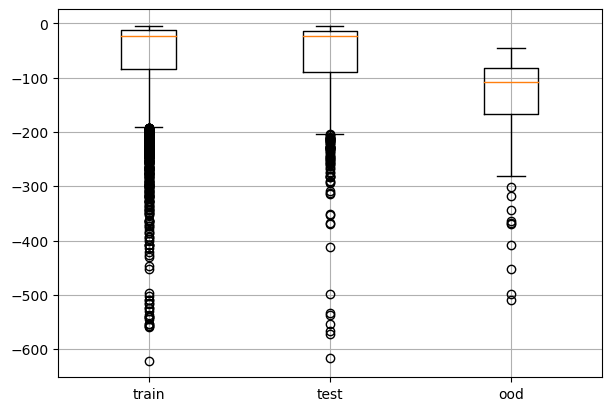

In [41]:
from sklearn.covariance import EllipticEnvelope

model = EllipticEnvelope(contamination=0.01, random_state=42)

model.fit(x_train)

train_scores = model.score_samples(x_train)
test_scores = model.score_samples(x_test)
ood_scores = model.score_samples(x_ood)


if 1:
    print(np.mean(train_scores))
    print(np.mean(test_scores))
    print(np.mean(ood_scores))


# boxplot
fig, ax1 = plt.subplots(figsize=(6, 4), constrained_layout=True)

labels = ['train', 'test', 'ood']
#ax1.set_ylim([40, 65])
ax1.boxplot([train_scores, test_scores, ood_scores], labels=labels)
ax1.grid()

plt.show()
##

(1374, 16)
(156, 16)
(1530, 16)


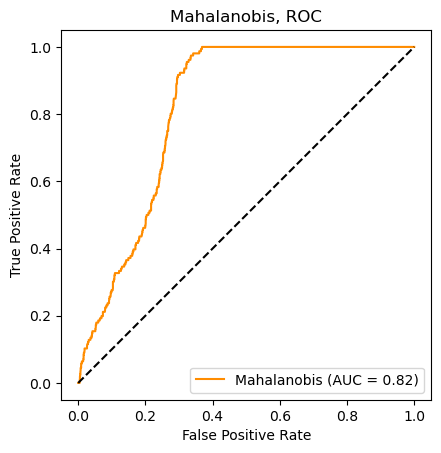

In [42]:
# ROC curve

print(x_test.shape)
print(x_ood.shape)
XX = np.concatenate((x_test,x_ood), axis=0)
print(XX.shape)

yy = [0]*x_test.shape[0] + [1]*x_ood.shape[0]      # 0 - ID, 1 - OOD


import math
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

yy_score = -model.decision_function(XX)

RocCurveDisplay.from_predictions(
    yy,
    yy_score,
    name="Mahalanobis",
    color="darkorange",
    pos_label=1
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mahalanobis, ROC")
plt.legend()
plt.show()